# Тестирование обученной сети на реальных фотографиях окурков 

### Будем пользоваться уже обученными нашей моделью весами, которые мы сохранили из ноутбука Cigarette_butt_segmentation.ipynb 

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
   

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
# У нас всего два класса, это окурок и фон 
num_classes = 2

# Получим экземпляр нашей модели с предобученными весами 
model = get_instance_segmentation_model(num_classes)

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/Cigs/weights.pth'

In [50]:
import torch
# загрузим сохраненные веса модели и не забудем перейти в eval режим 

model.load_state_dict(torch.load(PATH))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
    

In [0]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 8.0)

In [52]:
!git clone https://github.com/RostislavKorst/cigarette_butt_segmentation.git && pip install -r cigarette_butt_segmentation/requirements.txt
import sys; sys.path.append('./cigarette_butt_segmentation')

fatal: destination path 'cigarette_butt_segmentation' already exists and is not an empty directory.


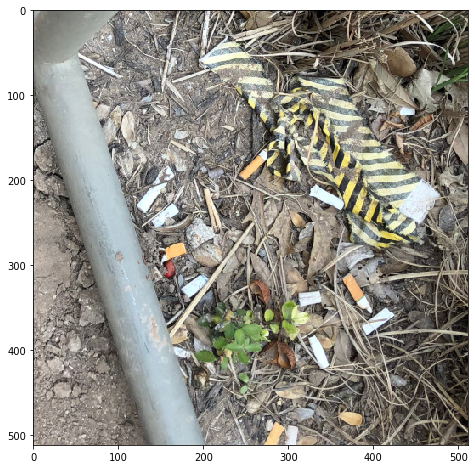

In [53]:
path_to_test = r'./cigarette_butt_segmentation/data/0006.JPG'

!cp './cigarette_butt_segmentation/data/0009.JPG' "0006.JPG"

img = Image.open(path_to_test)
plt.imshow(img) 

In [0]:
import torchvision.transforms as transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.eval()
with torch.no_grad():
    trans1 = transforms.ToTensor()
    img_tensor = trans1(img)
    prediction = model([img_tensor.to(device)])

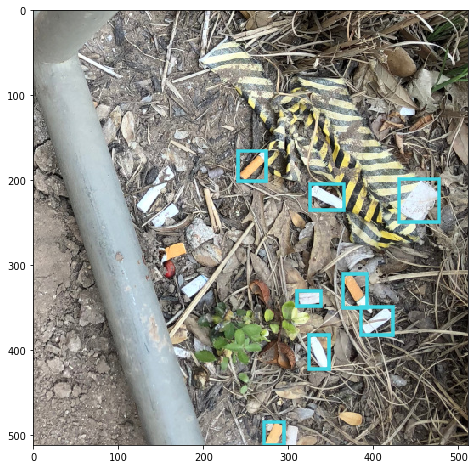

In [57]:
from gluoncv import utils

trans1 = transforms.ToTensor()
real_test_image = trans1(img)
utils.viz.plot_bbox(real_test_image.permute(1, 2, 0).numpy(), prediction[0]['boxes'].cpu().numpy())
plt.imshow(real_test_image.permute(1, 2, 0))
plt.show()

# Заключение: Модель достаточно хорошо детектирует сигаретные окурки, даже несмотря на то что она дообучалась всего три эпохи. Средний Precision и Recall около 0.9, что достаточно хорошо. 